In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time

from NiaPy.algorithms import BasicStatistics
from NiaPy.algorithms.basic import FishSchoolSearch
from NiaPy.algorithms.basic import ParticleSwarmAlgorithm
from NiaPy.task import StoppingTask, OptimizationType
from NiaPy.benchmarks import Benchmark
from scipy.optimize import OptimizeResult
from scipy.optimize import rosen, minimize
from scipy.interpolate import Rbf

In [20]:
class noisy_rosenbrock(Benchmark):
    def __init__(self):
        Benchmark.__init__(self, -3.0, 3.0)

    def function(self):
        def evaluate(D, sol):
            return rbf(*sol)
        return evaluate

In [21]:
def sgd(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.0024,
    mass=0.9,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    x = x0
    velocity = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):

        if callback and callback(x):
            break

        if jac == None:
            g = np.gradient((fun(benc)(len(x), x), fun(benc)(len(x), x+0.01)), 0.01)
        else:
            g = jac(x)

        velocity = mass * velocity - (1.0 - mass) * g
        x1 = x + learning_rate * velocity

    i += 1
    return OptimizeResult(x=x1, fun=fun(benc)(len(x), x), jac=g, nit=i, nfev=i, success=True)

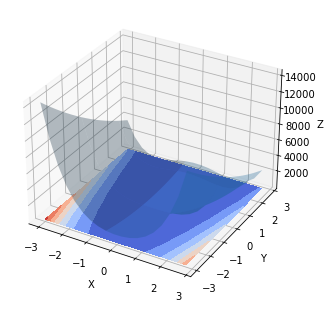

In [27]:
    nruns = 30
    dim = 2
    iter = 1000
    fes = 1000
    
    x = np.linspace(-3, 3, 20)
    x, y = np.meshgrid(x, x)
    noise = np.random.uniform(size=(np.shape(x)))
    u = rosen((x, y)) + noise
    rbf = Rbf(x, y, u)

    benc = noisy_rosenbrock()
    benc.plot3d()

Для тестирования работы алгоритмов на  зашумленной функция Розенброка было проведено 30 запусков для каждого алгоритма, установлено ограничение по количеству итераций и количеству вызовов функции - 1000 

In [23]:
    Time = list()
    x_fss = list()
    y_fss = list()
    stats = np.zeros(nruns)
    print("Fish School Search")
    for i in range(nruns):
        task = StoppingTask(D=dim, nGEN=iter, nFES=fes,  optType=OptimizationType.MINIMIZATION,
                            benchmark=noisy_rosenbrock())

        algo = FishSchoolSearch(NP=30, SI_init=0.1, SI_final=2, SV_init=0.1,
                                SV_final=2, min_w=0.1, w_scale=0.7)

        timer = time.perf_counter()
        best = algo.run(task)
        Time.append(time.perf_counter() - timer)

        stats[i] = best[1]
        x_fss.append(best[0][0])
        y_fss.append(best[0][1])

    stat = BasicStatistics(stats)
    print(stat.generate_standard_report())
    print("Execution time ", np.mean(Time))

Fish School Search
Min: -11.529841606941773, Max: 0.8213134891448135, Mean: -0.8830731812846352, Median: 0.29449471070984146, Std. 3.067494625755768
Execution time  0.13967457000000347


In [24]:
    Time = list()
    x_sgd = list()
    y_sgd = list()
    stats = np.zeros(nruns)
    print("\nStochastic Gradient Descent")
    for i in range(nruns):
        x0 = np.random.uniform(size=dim)
        timer = time.perf_counter()
        res_sgd = minimize(noisy_rosenbrock.function, x0, method=sgd, jac=None)
        Time.append(time.perf_counter() - timer)

        stats[i] = res_sgd.fun
        x_sgd.append(res_sgd.x[0])
        y_sgd.append(res_sgd.x[1])

    stat = BasicStatistics(stats)
    print(stat.generate_standard_report())
    print("Execution time ", np.mean(Time))


Stochastic Gradient Descent
Min: 0.700931275554467, Max: 92.99231888152644, Mean: 15.954188738978216, Median: 5.386615670291576, Std. 24.24206978629347
Execution time  0.19829840666665557


In [25]:
    Time = list()
    x_spo = list()
    y_spo = list()
    stats = np.zeros(nruns)
    print("\nParticleSwarmAlgorithm")
    for i in range(nruns):
        task = StoppingTask(D=dim, nGEN=iter, nFES=fes, optType=OptimizationType.MINIMIZATION,
                            benchmark=noisy_rosenbrock())

        algo = ParticleSwarmAlgorithm(NP=30, C1=1, C2=1, w=0.5, vMin=-1, vMax=0.5)

        timer = time.perf_counter()
        best = algo.run(task)
        Time.append(time.perf_counter() - timer)

        stats[i] = best[1]
        x_spo.append(best[0][0])
        y_spo.append(best[0][1])

    stat = BasicStatistics(stats)
    print(stat.generate_standard_report())
    print("Execution time ", np.mean(Time))


ParticleSwarmAlgorithm
Min: -19.784852438577218, Max: 4.307363966916455, Mean: -1.443518175208131, Median: 0.4224623169284314, Std. 5.412412185129608
Execution time  0.1431947133333248


На полученных графиках видно, что SGD менее подвержен зашумлению и находится в области истинного минимума, в то время как роевые алгоритмы застревают в локальных

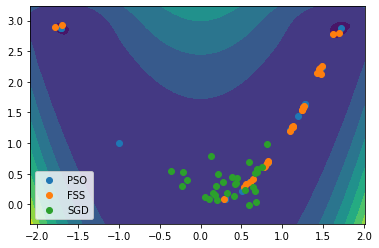

In [26]:
    x = np.linspace(min(x_spo + x_fss + x_sgd) - 0.3, max(x_spo + x_fss + x_sgd) + 0.3)
    y = np.linspace(min(y_spo + y_fss + y_sgd) - 0.3, max(y_spo + y_fss + y_sgd) + 0.3)
    x, y = np.meshgrid(x, y)
    plt.contourf(x, y, noisy_rosenbrock.function(benc)(dim, (x, y)))

    plt.scatter(x_spo, y_spo, label="PSO")
    plt.scatter(x_fss, y_fss, label="FSS")
    plt.scatter(x_sgd, y_sgd, label="SGD")

    plt.legend()
    plt.show()